
image 1/1 F:\ABDUL\ABDUL 2024\CAR_PRICE_PRE_ BASED_CAR_DAMAGE_DEC\car_price\COMBINE\Dataset\train\images\0090_JPEG.rf.2f222d68948b1a2a9cd918e3d09932fe.jpg: 480x640 1 Rear-windscreen-Damage, 65.7ms
Speed: 2.1ms preprocess, 65.7ms inference, 0.8ms postprocess per image at shape (1, 3, 480, 640)
Results saved to runs\detect\predict7


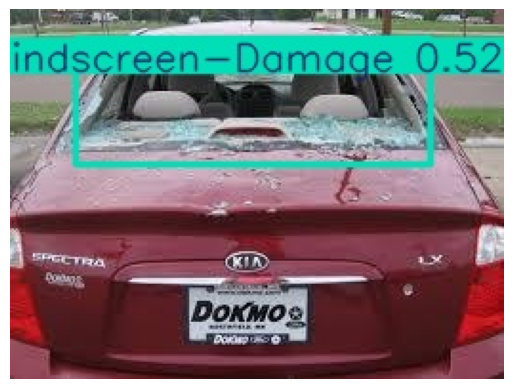

Predicted Selling Price after considering damages: 145210.0


In [10]:
from ultralytics import YOLO
import pandas as pd
import joblib
import os
import glob
import matplotlib.pyplot as plt
import cv2

# ------------------ Part 1: Load YOLO Model for Damage Detection ------------------

def detect_damages(image_path, save_dir="runs/detect"):
    """
    Detect damages from the car image using a trained YOLO model and display the annotated image.
    
    Args:
    - image_path (str): Path to the image file.
    - save_dir (str): Base directory where YOLO saves annotated images.

    Returns:
    - damage_count (int): Number of detected damages.
    """
    # Load the pre-trained YOLO model
    infer = YOLO("best_damage_detection_model.pt")
    
    # Run inference and specify save=True to save annotated images in save_dir
    results = infer.predict(image_path, save=True)
    
    # Get the latest created subdirectory in the save_dir
    latest_run_dir = max(glob.glob(os.path.join(save_dir, '*/')), key=os.path.getmtime)
    # Get the saved annotated image path
    save_path = os.path.join(latest_run_dir, os.path.basename(image_path))

    # Count the damages (number of bounding boxes)
    damage_count = len(results[0].boxes)
    
    # Load and display the annotated image
    annotated_image = cv2.imread(save_path)
    if annotated_image is not None:
        plt.imshow(cv2.cvtColor(annotated_image, cv2.COLOR_BGR2RGB))
        plt.axis('off')
        plt.show()
    else:
        print("Annotated image could not be loaded.")

    return damage_count


# ------------------ Part 2: Load Random Forest Model for Car Price Prediction ------------------

# Load the trained Random Forest model
model_rf = joblib.load('car_price_model.pkl')

# Load the dataset used for training to define X (features) correctly
df = pd.read_csv('Car_price.csv')

# Preprocess data (same as during training)
df.drop(columns=['name'], inplace=True)
categorical_cols = ['fuel', 'seller_type', 'transmission', 'owner']
df = pd.get_dummies(df, columns=categorical_cols, drop_first=True)

# Convert features to numerical values and handle missing values
df['mileage'] = df['mileage'].str.extract('(\d+\.\d+|\d+)').astype(float)
df['engine'] = df['engine'].str.extract('(\d+)').astype(float)
df['max_power'] = df['max_power'].str.extract('(\d+\.\d+|\d+)').astype(float)
df['torque'] = df['torque'].str.extract('(\d+\.\d+|\d+)').astype(float)
df.fillna(df.median(), inplace=True)

# Define features (X) and target variable (y)
X = df.drop(columns=['selling_price'])  # Features used for training

def preprocess_and_predict(input_data):
    """
    Preprocess the input data and predict the car price using the trained Random Forest model.
    
    Args:
    - input_data (dict): Input data for prediction.

    Returns:
    - predicted_price (float): Predicted car price.
    """
    # Process input data similar to training data preprocessing
    df_input = pd.DataFrame([input_data])
    categorical_cols = ['fuel', 'seller_type', 'transmission', 'owner']
    df_input = pd.get_dummies(df_input, columns=categorical_cols, drop_first=True)

    # Convert features to numerical values and handle missing values as done in training
    df_input['mileage'] = df_input['mileage'].str.extract('(\d+\.\d+|\d+)').astype(float)
    df_input['engine'] = df_input['engine'].str.extract('(\d+)').astype(float)
    df_input['max_power'] = df_input['max_power'].str.extract('(\d+\.\d+|\d+)').astype(float)
    df_input['torque'] = df_input['torque'].str.extract('(\d+\.\d+|\d+)').astype(float)
    df_input.fillna(df_input.median(), inplace=True)

    # Ensure all columns used during training are present in the input data
    missing_cols = set(X.columns) - set(df_input.columns)
    for col in missing_cols:
        df_input[col] = 0

    # Reorder columns to match the model's input structure
    df_input = df_input[X.columns]

    # Make predictions for car price based on input data
    predicted_price = model_rf.predict(df_input)[0]
    
    return predicted_price


# ------------------ Part 3: Combine Damage Detection and Car Price Prediction ------------------

# Example raw input data including image path for damage detection
raw_input_data = {
    'year': 2000,
    'km_driven': 145500,
    'fuel': 'Diesel',
    'seller_type': 'Individual',
    'transmission': 'Manual',
    'owner': 'First Owner',
    'mileage': '23.4 kmpl',
    'engine': '1248 CC',
    'max_power': '74 bhp',
    'torque': '190Nm',
    'seats': 5,
}

# Path to the car image for damage detection (local path)
image_path = r"F:\ABDUL\ABDUL 2024\CAR_PRICE_PRE_ BASED_CAR_DAMAGE_DEC\car_price\COMBINE\Dataset\train\images\0090_JPEG.rf.2f222d68948b1a2a9cd918e3d09932fe.jpg"  # Replace this with the local path to your image

# Detect the number of damages in the image and display the annotated image
damage_count = detect_damages(image_path)

# Predict the car price using the preprocessed data
predicted_price = preprocess_and_predict(raw_input_data)

# Adjust price based on the number of damages detected (assuming each damage reduces price by 1000)
final_price_estimate = predicted_price - (damage_count * 1000)

print(f"Predicted Selling Price after considering damages: {final_price_estimate}")
